Importando todas as bibliotecas necessárias

In [76]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.model_selection import cross_val_score, cross_validate

# Questão 1

Primeiramente, as colunas `CustomerId`, `RowNumber` e `Surname` foram eliminadas, pois pouco dizem a respeito dos clientes e sua relação com o *shopping*.

In [77]:
df = pd.read_csv('dataset/Churn_Modelling.csv', delimiter=',')
df = df.drop('CustomerId', axis=1)
df = df.drop('RowNumber', axis=1)
df = df.drop('Surname', axis=1)

df['Gender'] = preprocessing.LabelEncoder().fit_transform(df['Gender'])

Em seguida, uma breve análise exploratória os dados foi realizada. O primeiro gráfico ilustra a distribuição dos valores das colunas `EstimatedSalary` e `Balance` (da esquerda para a direita). É possível notar que ambos os casos apresentam uma grande variância, o que significa que o espectro de poder aquisitivo dos clientes é amplo. No segundo gráfico, percebe-se que há uma enorme quantidade de *outliers* no que diz respeito à idade dos clientes. A maioria dos clientes se situa na França, enquanto o resto é distribuído de maneira equânime entre Espanha e Alemanha, conforme ilustra o penúltimo gráfico. Por fim, observando-se o último gráfico, nota-se que a vasta maioria dos clientes optou por continuar no banco.

      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France       0   42       2       0.00              1   
1             608     Spain       0   41       1   83807.86              1   
2             502    France       0   42       8  159660.80              3   
3             699    France       0   39       1       0.00              2   
4             850     Spain       0   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France       1   39       5       0.00              2   
9996          516    France       1   35      10   57369.61              1   
9997          709    France       0   36       7       0.00              1   
9998          772   Germany       1   42       3   75075.31              2   
9999          792    France       0   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0   

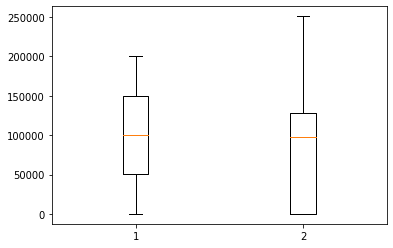

Idade


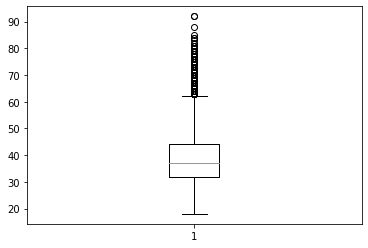

Pontuação de crédito


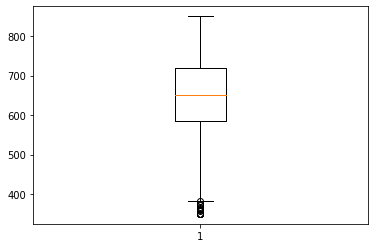

País


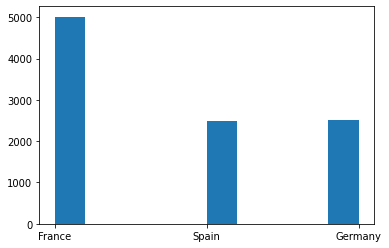

Saiu


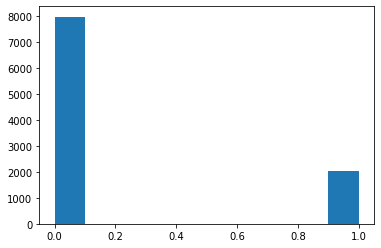

In [79]:

print(df)

fig = plt.figure()
print("Salário estimado e Saldo Bancário")
plt.boxplot([df['EstimatedSalary'].values, df['Balance'].values])
plt.show()
fig = plt.figure()

print("Idade")
plt.boxplot([df['Age'].values])
plt.show()
fig = plt.figure()

print("Pontuação de crédito")
plt.boxplot([df['CreditScore'].values])
plt.show()

fig = plt.figure()
print("País")
plt.hist(df['Geography'].values)
plt.show()


fig = plt.figure()
print("Saiu")
plt.hist(df['Exited'].values)
plt.show()

Uma nova variável foi criada com base no salário dos clientes. Isso foi feito de forma a dividí-los em diferentes grupos. Para isso, criou-se uma nova coluna `SalaryGroup`, que divide os clientes em 5 faixas salariais, que variam de 0 a 4.

In [80]:
for col in [pd.get_dummies(df['Geography'])]:
    df = df.join(col)
df = df.drop('Geography', axis=1)

df['SalaryGroup'] = pd.DataFrame(pd.cut(df['EstimatedSalary'], bins=5, labels=np.arange(5), right=False))

print(df['SalaryGroup'])

0       2
1       2
2       2
3       2
4       1
       ..
9995    2
9996    2
9997    1
9998    2
9999    0
Name: SalaryGroup, Length: 10000, dtype: int64


Para a classificação, realizou-se uma comparação entre árvore de decisão e *random forest*. Isso foi feito utilizando-se o método `StratifiedKFold` para particionar a base de dados em conjuntos de treinamento e teste. Os testes foram feitos utilizando-se várias combinações diferentes de dois hiperparâmetros de cada modelo: `max_depth` e `n_estimators` para o *random forest*, e `max_depth` e `min_samples_split` para árvore de decisão. A medida utilizada para aferir os resultados foi a `log_loss`, muito usada para problemas de classificação. A medida penaliza drasticamente diferenças entre o valor real do alvo e o valor previsto pelo modelo de classificação.

In [83]:
X = df.drop('Exited', axis=1).values
y = df['Exited'].values

skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

best_loss = 10e12
best_md, best_ne = 0, 0
best_matrix = 0
print("Random Forest")

for md, ne in itertools.product(range(2,2 + 10 * 10,10), range(2,40, 10)):
    avg_log_loss = 0
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf2 = RandomForestClassifier(max_depth=md, n_estimators=ne, random_state=1)
        clf2.fit(X_train,y_train)
        result2 = clf2.predict(X_test)
        
        avg_log_loss += metrics.log_loss(y_test, result2) / 10.0
    if avg_log_loss < best_loss:
        best_loss, best_md, best_ne = avg_log_loss, md, ne
        best_matrix = confusion_matrix(y_test, result2)

    print("max_depth =", md, ", n_estimators =", ne, ", log_loss médio:", avg_log_loss)
        
print("Melhor log_loss:", best_loss, " Melhor max_depth:", best_md, " Melhor n_estimators:", best_ne)
print(best_loss, best_md, best_ne)
print(best_matrix)

best_loss = 10e12
best_md, best_ne = 0, 0
best_matrix = 0
print("Decision Tree")

for md, ne in itertools.product(range(2,2 + 10 * 8,8), range(1,11)):
    avg_log_loss = 0
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf1 = tree.DecisionTreeClassifier(max_depth=md, min_samples_split=ne / 10.0  , random_state=1)
        clf1.fit(X_train, y_train)
        result1 = clf1.predict(X_test)
        
        avg_log_loss += metrics.log_loss(y_test, result1) / 10.0
    if avg_log_loss < best_loss:
        best_loss, best_md, best_ne = avg_log_loss, md, ne
        best_matrix = confusion_matrix(y_test, result1)

    print("max_depth =", md, ", min_samples_split =", ne / 10.0, ", log_loss médio:", avg_log_loss)
        
print("Melhor log_loss:", best_loss, " Melhor max_depth:", best_md, " Melhor min_samples_split:", best_ne / 10.0)
print(best_matrix)

Random Forest
max_depth = 2 , n_estimators = 2 , log_loss médio: 6.807593387155097
max_depth = 2 , n_estimators = 12 , log_loss médio: 6.78686956159995
max_depth = 2 , n_estimators = 22 , log_loss médio: 6.627991270143103
max_depth = 2 , n_estimators = 32 , log_loss médio: 6.5761831055507365
max_depth = 12 , n_estimators = 2 , log_loss médio: 6.351728954869887
max_depth = 12 , n_estimators = 12 , log_loss médio: 4.897621441244581
max_depth = 12 , n_estimators = 22 , log_loss médio: 4.8458123171353
max_depth = 12 , n_estimators = 32 , log_loss médio: 4.780187522548567
max_depth = 22 , n_estimators = 2 , log_loss médio: 6.0304943464743115
max_depth = 22 , n_estimators = 12 , log_loss médio: 5.139395754559705
max_depth = 22 , n_estimators = 22 , log_loss médio: 4.997786851300314
max_depth = 22 , n_estimators = 32 , log_loss médio: 4.9874252183818415
max_depth = 32 , n_estimators = 2 , log_loss médio: 6.058128006261761
max_depth = 32 , n_estimators = 12 , log_loss médio: 5.132487359602779


Para ambos os modelos, preservou-se os hiperparâmetros que resultaram no menor valor médio de `log_loss`. Em ambos os casos, tanto o valor de `log_loss` quanto a matriz de confusão demonstraram que o método é, de certa forma, eficaz. No entanto, é possível notar uma grande proporção de falsos negativos (i.e., clientes que não deixaram o banco, mas foram classificados como tal). Isso provavelmente se deve ao fato de que o método `StratifiedKFold` mantém as proporções da base de dados original, na qual o número de clientes que não deixaram o banco é muito maior. Por isso, ambos os modelos acabaram se aperfeiçoando apenas em detectar negativos. Dito isso, o `undersampling` pode ser uma possível solução para o problema.

Note que, no caso do *random forest*, os melhores resultados foram obtidos com uma profundidade máxima relativamente baixa. Porém, foi necessário um valor alto de `n_estimators`, algo que sacrifica a interpretabilidade do modelo, bem como o tempo computacional necessário para realizar o treinamento. De forma similar ao caso anterior, o aumento da profundidade máxima não proveu ganhos para a árvore e decisão, que alcançaram um melhor resultado com `min_sample_split = 10%` do número de observações. Em suma, dar mais liberdade ao modelo para gerar nós na árvore binária foi mais vantajoso.

# Questão 3

Primeiramente, os dados tiveram que ser normalizados. Além disso, a coluna `CustomerID` foi removida.

In [89]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

df = pd.read_csv('dataset/Mall_Customers.csv', delimiter=',')

df = df.drop('CustomerID', axis=1)
df['Genre'] = preprocessing.LabelEncoder().fit_transform(df['Genre'])

df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df.values))
print(df)

       0         1         2         3
0    1.0  0.019231  0.000000  0.387755
1    1.0  0.057692  0.000000  0.816327
2    0.0  0.038462  0.008197  0.051020
3    0.0  0.096154  0.008197  0.775510
4    0.0  0.250000  0.016393  0.397959
..   ...       ...       ...       ...
195  0.0  0.326923  0.860656  0.795918
196  0.0  0.519231  0.909836  0.275510
197  1.0  0.269231  0.909836  0.744898
198  1.0  0.269231  1.000000  0.173469
199  1.0  0.230769  1.000000  0.836735

[200 rows x 4 columns]


Dois algoritmos de clusterizaçãod distintos foram utilizados: K-means e Hierárquico. Para o útlimo, utilizou-se linkagens simples e completa. Os modelos, que foram testados com três valores distintos para `k`, tiveram sua eficácia aferida por meio da medida de silhueta, que indica, de forma resumida, o quanto um indivíduo de fato se encaixa no seu *cluster*.

In [100]:
for n in [5, 15, 25]:
    print("#######################################")
    print("Número de clusters:", n)
    print()
    for link in ['single','complete']:
        linked = AgglomerativeClustering(n_clusters=n, linkage=link).fit(df.values)
        print("Tipo: hierárquico")
        print("Linkagem:", link)
        print("Silhouette score: ", metrics.silhouette_score(df.values, linked.labels_, metric='euclidean'))
        print()

    kmeans = KMeans(n_clusters=n, random_state=0).fit(df.values)
    print("Tipo: k-means")
    print("Silhouette score: ", metrics.silhouette_score(df.values, kmeans.labels_, metric='euclidean'))
    print("#######################################")

#######################################
Número de clusters: 5

Tipo: hierárquico
Linkagem: single
Silhouette score:  0.1589396978918364

Tipo: hierárquico
Linkagem: complete
Silhouette score:  0.30316439293019537

Tipo: k-means
Silhouette score:  0.3696634492724439
#######################################
#######################################
Número de clusters: 15

Tipo: hierárquico
Linkagem: single
Silhouette score:  0.043446369213284416

Tipo: hierárquico
Linkagem: complete
Silhouette score:  0.4181727381589176

Tipo: k-means
Silhouette score:  0.4339512967690127
#######################################
#######################################
Número de clusters: 25

Tipo: hierárquico
Linkagem: single
Silhouette score:  0.0957339859760526

Tipo: hierárquico
Linkagem: complete
Silhouette score:  0.3970319495029798

Tipo: k-means
Silhouette score:  0.37780307583437034
#######################################


No caso do algoritmo k-means, o melhor resultado foi obtido com `k=5`. A medida de silhueta piora quando `k` decresce ou aumenta, o que indica que o número ideal de *clusters* se encontra próximo de 15. No caso do hierárquico, a linkagem simples apresenta sempre uma medida de silhueta menor. Esse fenômeno é acentuado a medida que o valor de `k` aumenta. Isso provavelmente se deve ao fato de que o comportamento aglomerativo e, de certa forma, "guloso" do modelo hierárquico é pior no caso da linkagem simples.